In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/MC_Project/

/content/gdrive/My Drive/MC_Project


**Importing the necessary libraries**

In [ ]:
import pandas as pd
import os
from datetime import datetime, timedelta
import math
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pickle

from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

**Read the Data**

In [ ]:
data = pd.read_csv(os.getcwd() + '/Final_Data.csv')
data = data.iloc[::-1]
cgm_df = data['Value CGM']
bolus_df = data['Value Bolus']

In [ ]:
cgm = cgm_df.to_numpy()
bolus = bolus_df.to_numpy()

t_cgm = cgm[bolus > 0]

161.97326852976914
400.0
ModeResult(mode=array([110.]), count=array([11]))
Counter({110.0: 11, 139.0: 10, 169.0: 10, 129.0: 10, 143.0: 10, 121.0: 9, 172.0: 9, 118.0: 9, 124.0: 9, 99.0: 9, 145.0: 9, 130.0: 9, 136.0: 8, 105.0: 7, 138.0: 7, 126.0: 7, 106.0: 7, 202.0: 7, 109.0: 7, 123.0: 7, 176.0: 7, 137.0: 7, 122.0: 7, 142.0: 7, 162.0: 7, 140.0: 7, 135.0: 6, 108.0: 6, 186.0: 6, 206.0: 6, 201.0: 6, 128.0: 6, 153.0: 6, 133.0: 6, 205.0: 6, 177.0: 6, 165.0: 6, 112.0: 6, 159.0: 6, 113.0: 6, 189.0: 6, 117.0: 6, 167.0: 6, 246.0: 6, 127.0: 6, 114.0: 6, 144.0: 6, 132.0: 6, 119.0: 6, 163.0: 6, 61.0: 6, 192.0: 6, 115.0: 5, 111.0: 5, 116.0: 5, 179.0: 5, 149.0: 5, 174.0: 5, 190.0: 5, 102.0: 5, 161.0: 5, 187.0: 5, 217.0: 5, 160.0: 5, 164.0: 5, 183.0: 5, 125.0: 5, 67.0: 4, 175.0: 4, 219.0: 4, 233.0: 4, 226.0: 4, 75.0: 4, 216.0: 4, 150.0: 4, 95.0: 4, 239.0: 4, 195.0: 4, 173.0: 4, 209.0: 4, 131.0: 4, 98.0: 4, 171.0: 4, 107.0: 4, 194.0: 4, 198.0: 4, 191.0: 4, 210.0: 4, 193.0: 4, 93.0: 4, 200.0: 4, 258.0: 4

<BarContainer object of 240 artists>

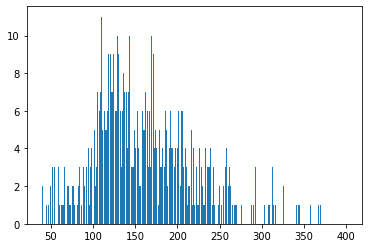

In [ ]:
print(t_cgm.mean())
print(t_cgm.max())
# print(t_cgm)
from scipy import stats
print(stats.mode(t_cgm))

from collections import Counter
print(Counter(t_cgm))
import matplotlib.pyplot as plt
plt.bar(list(Counter(t_cgm).keys()), list(Counter(t_cgm).values()))

**TimeShift to prepare data for RNN input**

In [ ]:
def get_moving_timeshift(values, time_stamps = 48, shift=1, remove_na = False):
    df = pd.DataFrame(values)
    columns = columns = [df.shift(i) for i in range(time_stamps, -1*shift, -1)]

    entire_data = pd.concat(columns, axis=1)
    entire_data.columns = list(range(0, len(entire_data.columns)))
    if remove_na:
        entire_data = entire_data.dropna(how='any', axis=0)
    
    return entire_data.to_numpy()

In [ ]:
time_stamps = 120
shift=6
data_rnn = pd.DataFrame(get_moving_timeshift(cgm_df.to_numpy(), time_stamps=time_stamps, shift=shift, remove_na = True))
data_rnn

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,...,64.0,64.0,65.0,64.0,72.0,72.0,90.0,81.0,81.0,81.0,92.0,93.0,89.0,99.0,106.0,114.0,115.0,115.0,115.0,124.0,112.0,119.0,125.0,193.0,199.0,199.0,199.0,199.0,199.0,199.0,350.0,350.0,350.0,350.0,248.0,248.0,248.0,248.0,262.0,274.0
1,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,...,64.0,65.0,64.0,72.0,72.0,90.0,81.0,81.0,81.0,92.0,93.0,89.0,99.0,106.0,114.0,115.0,115.0,115.0,124.0,112.0,119.0,125.0,193.0,199.0,199.0,199.0,199.0,199.0,199.0,350.0,350.0,350.0,350.0,248.0,248.0,248.0,248.0,262.0,274.0,274.0
2,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,...,65.0,64.0,72.0,72.0,90.0,81.0,81.0,81.0,92.0,93.0,89.0,99.0,106.0,114.0,115.0,115.0,115.0,124.0,112.0,119.0,125.0,193.0,199.0,199.0,199.0,199.0,199.0,199.0,350.0,350.0,350.0,350.0,248.0,248.0,248.0,248.0,262.0,274.0,274.0,274.0
3,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,...,64.0,72.0,72.0,90.0,81.0,81.0,81.0,92.0,93.0,89.0,99.0,106.0,114.0,115.0,115.0,115.0,124.0,112.0,119.0,125.0,193.0,199.0,199.0,199.0,199.0,199.0,199.0,350.0,350.0,350.0,350.0,248.0,248.0,248.0,248.0,262.0,274.0,274.0,274.0,274.0
4,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,314.0,...,72.0,72.0,90.0,81.0,81.0,81.0,92.0,93.0,89.0,99.0,106.0,114.0,115.0,115.0,115.0,124.0,112.0,119.0,125.0,193.0,199.0,199.0,199.0,199.0,199.0,199.0,350.0,350.0,350.0,350.0,248.0,248.0,248.0,248.0,262.0,274.0,274.0,274.0,274.0,274.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34970,279.0,289.0,288.0,287.0,284.0,277.0,263.0,242.0,228.0,185.0,186.0,178.0,69.0,51.0,41.0,41.0,41.0,41.0,48.0,61.0,61.0,61.0,90.0,101.0,115.0,129.0,79.0,69.0,49.0,49.0,49.0,49.0,49.0,73.0,83.0,90.0,87.0,82.0,73.0,66.0,...,158.0,158.0,158.0,160.0,164.0,167.0,166.0,165.0,164.0,166.0,167.0,172.0,174.0,182.0,186.0,193.0,194.0,185.0,184.0,178.0,180.0,174.0,162.0,151.0,148.0,146.0,140.0,157.0,159.0,148.0,134.0,131.0,140.0,150.0,140.0,137.0,130.0,128.0,127.0,126.0
34971,289.0,288.0,287.0,284.0,277.0,263.0,242.0,228.0,185.0,186.0,178.0,69.0,51.0,41.0,41.0,41.0,41.0,48.0,61.0,61.0,61.0,90.0,101.0,115.0,129.0,79.0,69.0,49.0,49.0,49.0,49.0,49.0,73.0,83.0,90.0,87.0,82.0,73.0,66.0,66.0,...,158.0,158.0,160.0,164.0,167.0,166.0,165.0,164.0,166.0,167.0,172.0,174.0,182.0,186.0,193.0,194.0,185.0,184.0,178.0,180.0,174.0,162.0,151.0,148.0,146.0,140.0,157.0,159.0,148.0,134.0,131.0,140.0,150.0,140.0,137.0,130.0,128.0,127.0,126.0,124.0
34972,288.0,287.0,284.0,277.0,263.0,242.0,228.0,185.0,186.0,178.0,69.0,51.0,41.0,41.0,41.0,41.0,48.0,61.0,61.0,6

**Getting the static features of the data to input in GRU static layer**

In [ ]:
def get_static_features(values):
    df = pd.DataFrame(values)
    result = pd.DataFrame()
    
    result['mean'] = df.mean(axis=1)
    result['median']= df.median(axis=1)
    result["std"] = df.std(axis=1)
    result['iqr'] = df.quantile(0.75,axis=1)-df.quantile(0.25,axis=1)
    result['low'] = df.min(axis=1)
    result['high'] = df.max(axis=1)
    result['gfi'] = ((df.diff(axis=1)**2).mean(axis=1))**0.5
    result['mag'] = df.diff(axis=1).abs().mean(axis=1)
    result['gcf'] = result['gfi'] / result['mean']
    result['cv'] = (result['std']*100) / result['mean']
    result['skew'] = df.skew(axis=1)
    result['kurtosis'] = df.kurtosis(axis=1)
    
    return result.to_numpy()

In [ ]:
data_static = pd.DataFrame(get_static_features(data_rnn.iloc[:,0:time_stamps].to_numpy()))
data_static

,0,1,2,3,4,5,6,7,8,9,10,11
0,199.591667,199.0,112.959240,233.00,43.0,350.0,22.661187,7.630252,0.113538,56.595168,-0.055512,-1.822546
1,199.041667,199.0,112.557466,233.00,43.0,350.0,24.514444,8.487395,0.123162,56.549700,-0.049495,-1.814819
2,198.491667,199.0,112.151533,233.00,43.0,350.0,24.514444,8.487395,0.123504,56.501885,-0.043566,-1.806915
3,197.941667,199.0,111.741395,233.00,43.0,350.0,24.514444,8.487395,0.123847,56.451680,-0.037727,-1.798835
4,197.391667,199.0,111.327007,233.00,43.0,350.0,24.514444,8.487395,0.124192,56.399041,-0.031983,-1.790581
...,...,...,...,...,...,...,...,...,...,...,...,...
34970,135.433333,147.0,58.081619,76.50,41.0,289.0,14.558200,6.966387,0.107493,42.885764,0.513827,0.488129
34971,134.275000,147.0,56.560515,74.50,41.0,289.0,14.558200,6.966387,0.108421,42.122893,0.479144,0.558485
34972,133.008333,147.0,54.739029,73.25,41.0,288.0,14.560508,6.983193,0.109471,41.154586,0.406202,0.538433
34973,131.691667,147.0,52.847139,72.25,41.0,287.0,14.574353,7.033613,0.110670,40.129448,0.311851,0.458986


**Preapring the training and testing data**

In [ ]:
def get_splits(values, split_per=0.8):
    df = pd.DataFrame(values)
    columns = len(df.columns)
    
    train_size = int(len(df) * split_per)
    test_size = len(df) - train_size
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    
    return train.to_numpy(), test.to_numpy()

In [ ]:
gru_train, gru_test = get_splits(data_rnn.to_numpy())
x_static_train, x_static_test = get_splits(data_static.to_numpy())

In [ ]:
def get_moving_diff(values, replace_na=False):
    df = pd.DataFrame(values)
    diff_X = df.diff(axis=1)
    
    if replace_na:
        diff_X = diff_X.fillna(0.0)
    else:
        diff_X = diff_X.dropna(axis=1)
    
    return diff_X.to_numpy()

In [ ]:
gru_train = get_moving_diff(gru_train, replace_na = True)
gru_test = get_moving_diff(gru_test, replace_na = True)

In [ ]:
def rescaling(value, newscale=(-1,1), oldscale=(-100,100)):
    (old_min, old_max) = oldscale
    (new_min, new_max) = newscale
    
    new_value= (new_max-new_min)/(old_max-old_min)*(value-old_max)+new_max
    
    return new_value

In [ ]:
gru_train = np.vectorize(rescaling)(gru_train)
gru_test = np.vectorize(rescaling)(gru_test)

In [ ]:
x_gru_train, y_train = gru_train[:,0:time_stamps], gru_train[:,time_stamps:]
x_gru_test, y_test = gru_test[:,0:time_stamps], gru_test[:,time_stamps:]

In [ ]:
print(x_gru_train.shape, x_gru_test.shape)
print(x_static_train.shape, x_static_test.shape)
print(y_train.shape, y_test.shape)

(27980, 120) (6995, 120)
(27980, 12) (6995, 12)
(27980, 6) (6995, 6)


In [ ]:
scaler = StandardScaler()
scaler.fit(x_static_train,y_train)

x_static_train = scaler.transform(x_static_train)
x_static_test = scaler.transform(x_static_test)

In [ ]:
x_gru_train = np.expand_dims(x_gru_train, axis=-1)
x_gru_test = np.expand_dims(x_gru_test, axis=-1)

x_static_train = np.expand_dims(x_static_train, axis=-1)
x_static_test = np.expand_dims(x_static_test, axis=-1)

In [ ]:
print(x_gru_train.shape, x_gru_test.shape)
print(x_static_train.shape, x_static_test.shape)
print(y_train.shape, y_test.shape)

(27980, 120, 1) (6995, 120, 1)
(27980, 12, 1) (6995, 12, 1)
(27980, 6) (6995, 6)


In [ ]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

**Defining the model**

In [ ]:
# 32, 16, 30 
model = keras.Sequential()

gru_input = layers.Input(shape=(x_gru_train.shape[1], x_gru_train.shape[2]))
static_input = layers.Input(shape=(x_static_train.shape[1], x_static_train.shape[2]))

gru_stack_1, gru_stack_1_c = layers.GRU(120, return_sequences=True, return_state=True)(gru_input)
drop_gru_1 = layers.Dropout(0.05)(gru_stack_1)

gru_stack_2, gru_stack_2_c = layers.GRU(120, return_sequences=True, return_state=True)(drop_gru_1)

static_dense = layers.Dense(2)(static_input)
static_flatten = layers.Flatten()(static_dense)

concatenate = layers.Concatenate()([gru_stack_1_c, gru_stack_2_c, static_flatten])


drop_2 = layers.Dropout(0.1)(concatenate)
dense_1 = layers.Dense(64)(drop_2)
drop_3 = layers.Dropout(0.05)(dense_1)
dense_2 = layers.Dense(16)(drop_3)
drop_4 = layers.Dropout(0.02)(dense_2)

output = layers.Dense(6)(drop_4)


model = models.Model(inputs=[gru_input, static_input], outputs=output)
model.summary()
model.compile(
    loss='mse', 
    optimizer='adam', 
    metrics=[r_square,'mae']
)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 1)]     0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 120, 120), ( 44280       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 120, 120)     0           gru[0][0]                        
_______________________________________________________________________________________

**Training the model**

In [ ]:
filepath = "model_gru_static-{epoch:03d}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='r_square', verbose=1,
    save_best_only=False, save_weights_only=True, mode='auto', period=1)

history = model.fit(
    [x_gru_train, x_static_train], y_train,
    epochs=50,
    batch_size=48,
    verbose=1,
    validation_data=([x_gru_test, x_static_test], y_test),
    shuffle=True,
    callbacks=[checkpoint]
)

Epoch 1/50
581/583 [============================>.] - ETA: 0s - loss: 0.1317 - r_square: -6.7110 - mae: 0.2414
Epoch 00001: saving model to model_gru_static-001.h5
583/583 [==============================] - 9s 16ms/step - loss: 0.1316 - r_square: -6.7003 - mae: 0.2413 - val_loss: 0.0195 - val_r_square: -0.1199 - val_mae: 0.0678
Epoch 2/50
581/583 [============================>.] - ETA: 0s - loss: 0.0885 - r_square: -4.1542 - mae: 0.1964
Epoch 00002: saving model to model_gru_static-002.h5
583/583 [==============================] - 9s 15ms/step - loss: 0.0884 - r_square: -4.1482 - mae: 0.1963 - val_loss: 0.0198 - val_r_square: -0.1785 - val_mae: 0.0709
Epoch 3/50
581/583 [============================>.] - ETA: 0s - loss: 0.0635 - r_square: -2.6871 - mae: 0.1639
Epoch 00003: saving model to model_gru_static-003.h5
583/583 [==============================] - 9s 16ms/step - loss: 0.0634 - r_square: -2.6829 - mae: 0.1638 - val_loss: 0.0196 - val_r_square: -0.1117 - val_mae: 0.0682
Epoch 4/50

**Plotting the results of training**

dict_keys(['loss', 'r_square', 'mae', 'val_loss', 'val_r_square', 'val_mae'])


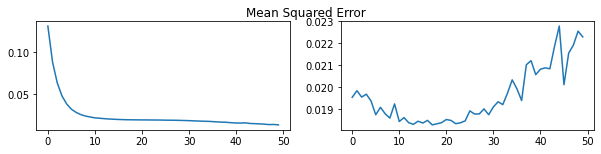

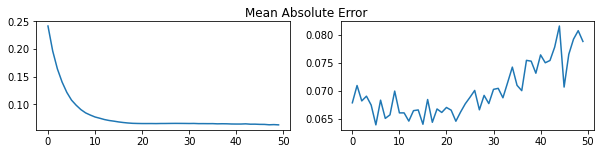

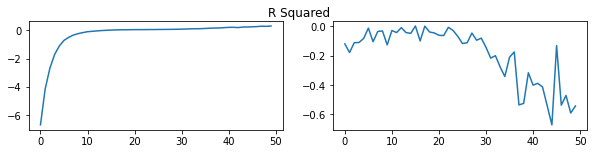

In [ ]:
print(history.history.keys())

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig1.suptitle('Mean Squared Error')
ax1.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig2.suptitle('Mean Absolute Error')
ax1.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])

fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig3.suptitle('R Squared')
ax1.plot(history.history['r_square'])
ax2.plot(history.history['val_r_square'])

**Predicting the values of the test data**

In [ ]:
testing_data = cgm_df.iloc[-400:-1].to_numpy()
testing_data = testing_data.reshape(1, 399)
testing_data.shape

(1, 399)

In [ ]:
scaler = pickle.load(open(os.getcwd()+'/scaler.pkl', 'rb'))

time_stamps = 120
ahead_pred = 48
org_lstm = testing_data[:,0:time_stamps]
y_ground = testing_data[:,time_stamps:time_stamps+ahead_pred]

y_pred = []
for i in range(ahead_pred):
    input_lstm = get_moving_diff(org_lstm, replace_na=True)
    input_lstm = np.vectorize(rescaling)(input_lstm)
    
    input_static = get_static_features(org_lstm)
    input_static = scaler.transform(input_static)
    
    input_lstm = np.expand_dims(input_lstm, axis=-1)
    input_static = np.expand_dims(input_static, axis=-1)

    pred = model.predict([input_lstm, input_static])
    pred = pred[0][0]
    pred = rescaling(pred, newscale=(-100,100), oldscale=(-1,1))
    pred = org_lstm[:,-1]+pred
    print(pred)
    
    if pred > int(pred)+0.5:
         pred = int(pred)+1.0
    else:
         pred = int(pred)+0.0
    y_pred.append(pred)
    pred = np.reshape(pred, (1,1))
    org_lstm = np.concatenate((org_lstm[:,1:], pred), axis=-1)

[134.43538001]
[141.30402768]
[148.57287592]
[149.1420667]
[146.81758878]
[146.85454098]
[156.83925536]
[171.73607868]
[165.95396784]
[116.5387038]
[108.79399461]
[106.87264448]
[107.61641387]
[111.31623107]
[108.26874065]
[91.47997814]
[83.64434576]
[88.62656319]
[99.24917811]
[108.28436816]
[113.81397973]
[116.49499436]
[115.48846698]
[112.69128691]
[111.0980169]
[110.26810255]
[110.59904293]
[113.1454962]
[115.65549459]
[119.34667116]
[122.15909088]
[125.21994945]
[128.14823128]
[131.15846279]
[134.24173272]
[137.14766094]
[139.99371667]
[142.83353515]
[145.66677216]
[148.61754058]
[151.67935526]
[154.76051965]
[157.80681755]
[160.83497348]
[163.52657663]
[166.45059375]
[167.44841019]
[167.25543254]


In [ ]:
y_pred = np.array(y_pred)
y_pred = y_pred.reshape((1, 48))
y_pred.shape

(1, 48)

In [ ]:
y_ground.shape

(1, 48)

In [ ]:
y_pred

array([[134., 141., 149., 149., 147., 147., 157., 172., 166., 117., 109.,
        107., 108., 111., 108.,  91.,  84.,  89.,  99., 108., 114., 116.,
        115., 113., 111., 110., 111., 113., 116., 119., 122., 125., 128.,
        131., 134., 137., 140., 143., 146., 149., 152., 155., 158., 161.,
        164., 166., 167., 167.]])

In [ ]:
y_ground

array([[131., 131., 131., 131., 140., 144., 144., 150., 141., 126., 114.,
        115.,  86.,  92.,  75.,  75.,  70.,  72.,  72.,  72.,  69.,  69.,
         69.,  63.,  63.,  67.,  67.,  70.,  70.,  69.,  65.,  62.,  63.,
         63.,  63.,  63.,  63.,  60.,  60.,  57., 104., 110., 110., 110.,
        110., 110., 110., 110.]])